# anuga to landlab: example 2

In this example we use [Anuga](https://github.com/GeoscienceAustralia/anuga_core) to create a mesh with variable resolution. With Anuga, we are able to specify regions and specific grid cell resolutions within those regions. In this example we will demonstrate this by doing the following:

1. Creation of an *Anuga* mesh with 2 regions of different resolutions
2. Create simple ridge that is in the center of the domain and each slope has a different cell resolution
3. Translate the *Anuga* mesh to a *landlab* grid
4. Run the *landlab* flow accumulation routine
5. Fill in elevation holes that were created in the mesh generation
6. Re-run the flow accumulation routine

### Import libraries

This notebook requires the *numpy*, *matplotlib*, *landlab* and *anuga* packages. See the [documentation](https://elbeejay.github.io/meshing-with-landlab/dependencies/index.html) for links to the source installation guides. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import anuga
import anuga.utilities.idwinterp as idt

### Generate the Anuga mesh

To generate the Anuga mesh we first define a bounding polygon that defines the outer extents. Then a region within the domain is defined `c_region` by listing points in counter-clockwise order that form a closed shape. The resolution (cell area) is defined for a low resolution and higher resolution region. Then the mesh is visualized so this distinction in resolution can be observed.

In [2]:
# define domain extents
bounding_polygon = [[0.0, 0.0],
                    [100.0, 0.0],
                    [100.0, 100.0],
                    [0.0, 100.0]]

In [3]:
# define a region of the domain to model in higher-res
c_region = [[0.0, 50.0], [100.0, 50.0], [100.0, 100.0], [0.0, 100.0]]

In [4]:
# define boundaries
boundary_tags = {'bottom': [0,1],
                'right': [1,2],
                'top': [2,3],
                'left': [3,0]}

In [5]:
# define low and high res values
low_res = 50
high_res = 1

In [6]:
# create the domain
domain = anuga.create_domain_from_regions(bounding_polygon,
                                          boundary_tags,
                                          maximum_triangle_area=low_res,
                                          interior_regions=[[c_region, high_res]],
                                          mesh_filename='test.msh')

Figure files for each frame will be stored in _plot


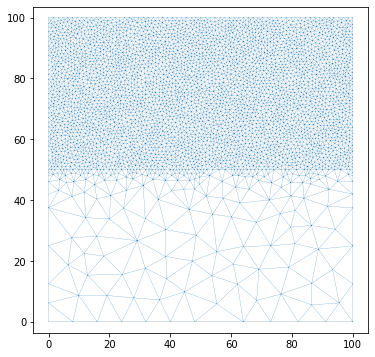

In [7]:
# visualize mesh
dplotter = anuga.Domain_plotter(domain)
plt.figure(figsize=(6,6))
plt.triplot(dplotter.triang, linewidth=0.2)
plt.axis('equal')
plt.show()

### Generate fake topography and assign to the mesh

Here we generate a simple sloped topography. This is defined using *numpy*, so it is on a regular grid. Built-in interpolation functionality from *anuga* is applied to interpolate from the regular grid to the *anuga* mesh. Lastly the elevation values are assigned to the mesh.

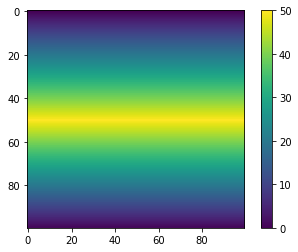

In [8]:
# create fake topography as a grid
topo_gridded = np.zeros((100, 100))
[a, b] = np.shape(topo_gridded)
for i in range(0, b):
    if i < b/2:
        topo_gridded[i, :] = i
    else:
        topo_gridded[i, :] = np.abs(i - 100)
        
grid_y, grid_x = np.mgrid[0:100, 0:100]

plt.figure()
plt.imshow(topo_gridded)
plt.colorbar()
plt.show()

In [9]:
# flatten
xval = grid_x.flatten()
yval = grid_y.flatten()
topoval = topo_gridded.flatten()

In [10]:
# interpolate gridded values to irregular grid
idwtree = idt.invdisttree(np.transpose((xval, yval)), topoval)
topo = idwtree(domain.centroid_coordinates, nnear=3, eps=0, p=1, weights=None)

In [11]:
# set values
domain.set_quantity('elevation', topo, location='centroids')

### Translate to landlab

To translate the mesh as well as the elevation values from *anuga* to *landlab*, first we need to identify the vertex coordinates and their corresponding elevation values. After that the `landlab.VoronoiDelaunayGrid` object is established using the coordinate values. This grid is plotted to ensure that the variable resolution is preserved. Then the elevation attribute is initialized for each node, and the translation of *anuga* elevation values to the *landlab* grid takes place. The resulting *landlab* grid with elevations is plotted next to the source elevation data to visually check them.

In [12]:
# get vertex coordinates and their elevation values
e = domain.get_quantity('elevation')
X, Y, A, V = e.get_vertex_values()
XY = np.column_stack((X,Y))

In [13]:
from landlab.grid import VoronoiDelaunayGrid
from landlab.plot.graph import plot_graph
worked = 0
while worked <= 25:
    try:
        grid = VoronoiDelaunayGrid(X,Y)
        worked = 100
    except Exception:
        worked += 1
        
print(worked)

100


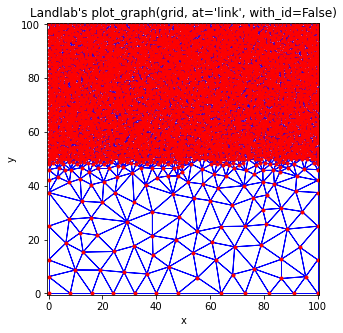

In [14]:
plt.figure(figsize=(5, 5))
plt.title("Landlab's plot_graph(grid, at='link', with_id=False)")
plot_graph(grid, at="link", with_id=False)

In [15]:
z_vals = grid.add_zeros("topographic__elevation", at="node")

In [16]:
# translating elevation from anuga grid to landlab grid
for i in range(0, len(grid.node_x)):
    ind = np.where(XY==[grid.node_x[i],grid.node_y[i]])[0][0]
    grid.at_node['topographic__elevation'][i] = A[ind]

/home/jayh/miniconda3/envs/espin/lib/python3.8/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_bad(color=color_for_closed)


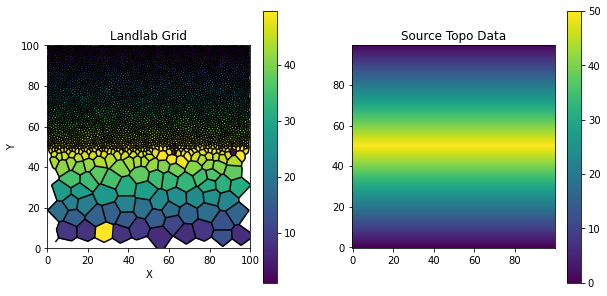

In [17]:
from landlab.plot.imshow import imshow_grid
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Landlab Grid')
imshow_grid(grid, 'topographic__elevation', show_elements=True, cmap='viridis')
plt.subplot(1,2,2)
plt.title('Source Topo Data')
plt.imshow(topo_gridded)
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

### Running the flow accumulator

Now the `landlab.FlowAccumulator` module is initialized and run. Using this on the variable resolution grid shows the impact grid resolution can have on model results (even on a simple sloped topography). The final cell plots the source elevation data on the left, the generated landlab grid with elevations in the center, and the resulting flow accumulation map on the right. 

In [18]:
from landlab.components import FlowAccumulator
from landlab.components import FlowDirectorSteepest
fa = FlowAccumulator(grid, 'topographic__elevation',
                     flow_director=FlowDirectorSteepest)

In [19]:
fa.run_one_step()

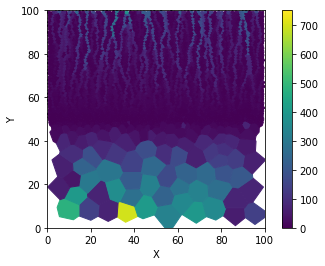

In [20]:
imshow_grid(grid, 'drainage_area', show_elements=False, cmap='viridis')

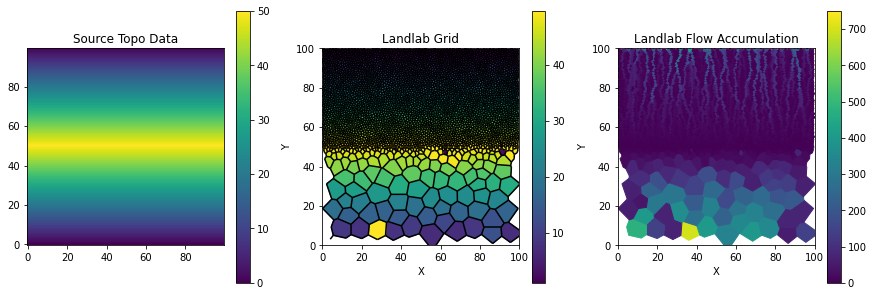

In [21]:
from landlab.plot.imshow import imshow_grid
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Source Topo Data')
plt.imshow(topo_gridded)
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(1,3,2)
plt.title('Landlab Grid')
imshow_grid(grid, 'topographic__elevation', show_elements=True, cmap='viridis')
plt.subplot(1,3,3)
plt.title('Landlab Flow Accumulation')
imshow_grid(grid, 'drainage_area', show_elements=False, cmap='viridis')
plt.show()

### Hole filling

If we look closely at the center panel in the figure above, we might notice that some cells near the ridge have low elevation values. This is likely due to the conversion process between the mesh types, leaving some unintended 'holes' in the topography. While this is not ideal, it is not too different from the 'holes' that are commonly found in DEMs. As such, there are built-in *landlab* components for dealing with 'holes'. We will first visualize the domain to see the holes, then apply the `landlab.LakeMapperBarnes` component to fill in the holes, and take a look at the resulting grid.

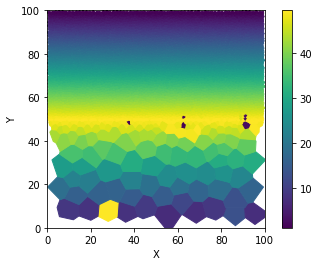

In [22]:
imshow_grid(grid, "topographic__elevation", show_elements=False, cmap='viridis')
plt.show()

In [23]:
from landlab.components import LakeMapperBarnes
z_init = z_vals.copy()
lmb = LakeMapperBarnes(grid, method='Steepest', surface=z_init, fill_flat=True,
                       redirect_flow_steepest_descent=False, track_lakes=False, ignore_overfill=True)
lmb.run_one_step()

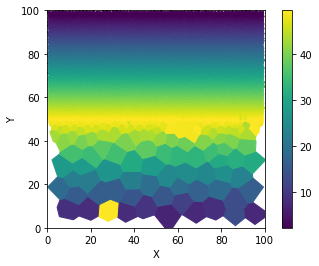

In [24]:
imshow_grid(grid, "topographic__elevation", show_elements=False, cmap='viridis')
plt.show()

### Re-running the FlowAccumulator

It is worth noting that the holes predominantly appeared in the 'coarse' region of the mesh, and therefore could be due to large irregular cells whose values were interpolated from a finer regular grid. Anyway, now that the holes are filled, we can re-run the `landlab.FlowAccumulator` component and take a look at how grid resolution impacts our results.

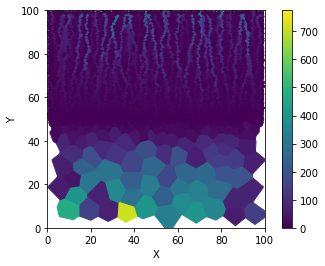

In [25]:
fa = FlowAccumulator(grid, 'topographic__elevation',
                     flow_director=FlowDirectorSteepest)
fa.run_one_step()
imshow_grid(grid, 'drainage_area', show_elements=False, cmap='viridis')